# Neural Network using Pytorch library

In [1]:
import os
import pandas as pd
import torch
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from torchmetrics.functional import mean_absolute_percentage_error

import numpy as np


## Check if hardware accelerators such as GPU or MPS are available, if not CPU

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [25]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('clean.csv')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']).values, df['price'].values, test_size=0.2, random_state=42)


scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize a scaler for the target variable
y_scaler = MinMaxScaler()

# Reshape y to be a 2D array (required for scalers)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Ensure target is 2D for regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and data loaders
train_dataset = FlightDataset(X_train_scaled, y_train_scaled)
test_dataset = FlightDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
import torch.nn.functional as F
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)  # Single output for regression

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x


In [6]:
input_size = X_train.shape[1]  # Number of features

model = PricePredictor(input_size).to(device)
print(model)

criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

PricePredictor(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


In [7]:
epochs = 250

for epoch in range(epochs):
    model.train()  # Training model
    total_loss = 0

    for inputs, targets in train_loader:
        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/250], Loss: 0.0329
Epoch [2/250], Loss: 0.0227
Epoch [3/250], Loss: 0.0206
Epoch [4/250], Loss: 0.0197
Epoch [5/250], Loss: 0.0192
Epoch [6/250], Loss: 0.0190
Epoch [7/250], Loss: 0.0189
Epoch [8/250], Loss: 0.0177
Epoch [9/250], Loss: 0.0168
Epoch [10/250], Loss: 0.0161
Epoch [11/250], Loss: 0.0157
Epoch [12/250], Loss: 0.0155
Epoch [13/250], Loss: 0.0154
Epoch [14/250], Loss: 0.0151
Epoch [15/250], Loss: 0.0151
Epoch [16/250], Loss: 0.0150
Epoch [17/250], Loss: 0.0149
Epoch [18/250], Loss: 0.0147
Epoch [19/250], Loss: 0.0147
Epoch [20/250], Loss: 0.0145
Epoch [21/250], Loss: 0.0145
Epoch [22/250], Loss: 0.0145
Epoch [23/250], Loss: 0.0145
Epoch [24/250], Loss: 0.0143
Epoch [25/250], Loss: 0.0141
Epoch [26/250], Loss: 0.0142
Epoch [27/250], Loss: 0.0142
Epoch [28/250], Loss: 0.0140
Epoch [29/250], Loss: 0.0138
Epoch [30/250], Loss: 0.0137
Epoch [31/250], Loss: 0.0137
Epoch [32/250], Loss: 0.0136
Epoch [33/250], Loss: 0.0137
Epoch [34/250], Loss: 0.0135
Epoch [35/250], Loss: 0

In [8]:
model.eval()  # Evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in test_loader:
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Loss: 0.0161


In [9]:
import torch
import numpy as np

# Ensure model is in evaluation mode (important for layers like dropout and batch norm)
model.eval()

# Initialize lists to store predictions and real values
predicted_prices = []
real_prices = []

# Disable gradient calculation (important for inference mode to save memory and computation)
with torch.no_grad():
    # Iterate through the DataLoader
    for x, y in test_loader:
        # Forward pass: get predictions
        predicted_price = model(x)  # Make predictions with the model

        # Store predictions and real values
        predicted_prices += predicted_price.cpu().numpy().tolist()  # Move to CPU and convert to list
        real_prices += y.cpu().numpy().tolist()  # Move to CPU and convert to list

# Convert lists to numpy arrays for easier handling
predicted_prices = np.array(predicted_prices)
real_prices = np.array(real_prices)

# Descale the predicted and real values if necessary
predicted_prices_descaled = y_scaler.inverse_transform(predicted_prices)
real_prices_descaled = y_scaler.inverse_transform(real_prices)

# Print real vs predicted values
for real, pred in zip(predicted_prices_descaled, real_prices_descaled):
    print(f"Real: {real[0]:.2f} \t Predicted: {pred[0]:.2f}")


Real: 44379.24 	 Predicted: 45185.00
Real: 69981.06 	 Predicted: 69179.00
Real: 58478.31 	 Predicted: 53937.00
Real: 63614.80 	 Predicted: 55377.00
Real: 44527.79 	 Predicted: 56702.00
Real: 56027.28 	 Predicted: 55502.00
Real: 65256.47 	 Predicted: 55997.00
Real: 52811.30 	 Predicted: 54684.00
Real: 58413.27 	 Predicted: 60978.00
Real: 50982.13 	 Predicted: 53937.00
Real: 52425.07 	 Predicted: 54841.00
Real: 53364.54 	 Predicted: 57017.00
Real: 55374.81 	 Predicted: 60978.00
Real: 51503.66 	 Predicted: 48718.00
Real: 56103.39 	 Predicted: 57017.00
Real: 51840.85 	 Predicted: 49553.00
Real: 27961.25 	 Predicted: 27792.00
Real: 71486.59 	 Predicted: 77329.00
Real: 70679.93 	 Predicted: 62448.00
Real: 49246.98 	 Predicted: 54777.00
Real: 48423.56 	 Predicted: 51707.00
Real: 62690.79 	 Predicted: 73369.00
Real: 39600.16 	 Predicted: 47586.00
Real: 52752.83 	 Predicted: 66077.00
Real: 38289.08 	 Predicted: 34460.00
Real: 60959.17 	 Predicted: 80544.00
Real: 53190.11 	 Predicted: 54608.00
R

In [34]:
real_tensor = torch.tensor(y_test_list)
predicted_tensor = torch.tensor(predicted_prices)

In [10]:
from utils import print_errors
from sklearn.metrics import r2_score

print_errors(real_prices_descaled, predicted_prices_descaled)
print(r2_score(real_prices_descaled, predicted_prices_descaled))

mean_squared_error :  54278021.99
mean_absolute_error :  5451.73
mean_absolute_percentage_error :  0.11
0.6040566494443653


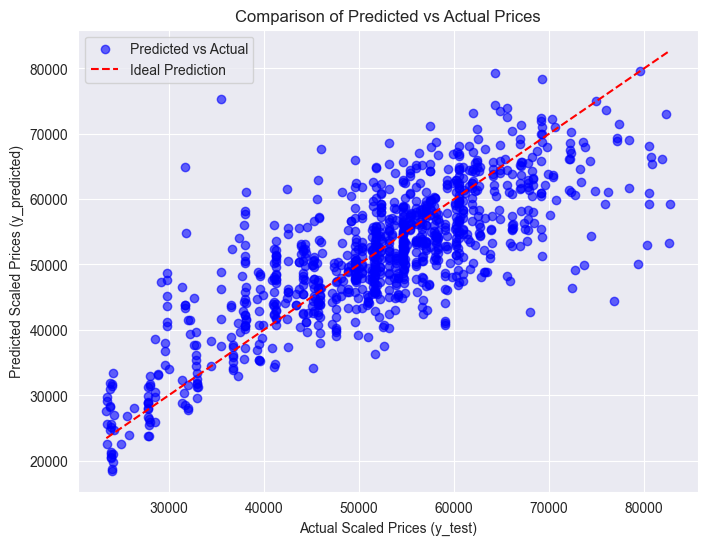

In [13]:
import matplotlib.pyplot as plt
from utils import scatter
scatter(real_prices_descaled, predicted_prices_descaled)


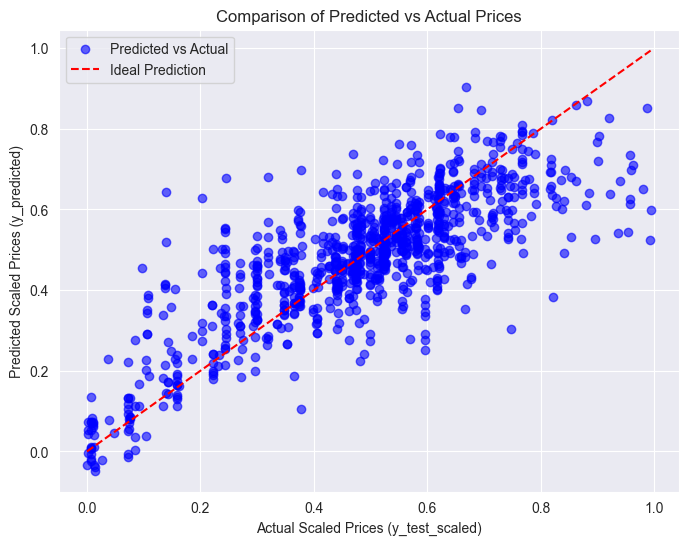

In [37]:
# Assuming y_predicted and y_test_scaled are numpy arrays or lists
plt.figure(figsize=(8, 6))
plt.scatter(y_test_list, predicted_prices, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test_list), max(y_test_list)], [min(y_test_list), max(y_test_list)], 'r--', label='Ideal Prediction')
plt.xlabel('Actual Scaled Prices (y_test_scaled)')
plt.ylabel('Predicted Scaled Prices (y_predicted)')
plt.title('Comparison of Predicted vs Actual Prices')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
np.random.random(50)

array([0.21860339, 0.45911842, 0.33012024, 0.97065076, 0.58989535,
       0.50171173, 0.95815764, 0.98427226, 0.40492739, 0.74180585,
       0.34459826, 0.16219646, 0.91353581, 0.03378731, 0.63786712,
       0.84917047, 0.27318152, 0.17496669, 0.65688421, 0.75395171,
       0.78500861, 0.33370556, 0.59866007, 0.66364995, 0.92788822,
       0.81866737, 0.27349613, 0.41906338, 0.73909785, 0.95944186,
       0.24381218, 0.66183994, 0.17762526, 0.63205894, 0.30581668,
       0.18420027, 0.22730934, 0.58804024, 0.88422905, 0.97536662,
       0.64208258, 0.57332085, 0.00396874, 0.10951044, 0.31785342,
       0.85367848, 0.24060749, 0.11601174, 0.94598004, 0.92128647])